Demo of variable autoencoder for MNIST digits.
If you are on colab, downgrade tensorflow to v2.15 
Also note that we will use dense layers (instead of convolutional layers)

In [4]:
import tensorflow as tf
print(tf.version.VERSION)

2.13.1


In [5]:
!pip install numpy==1.24.3
import numpy as np
import matplotlib.pyplot as pyplot

# The following downgrade only for colab
#!pip install tensorflow==2.15

import tensorflow as tf
print(tf.version.VERSION)
from keras.datasets import mnist
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras.metrics import binary_crossentropy
from scipy.stats import norm

Defaulting to user installation because normal site-packages is not writeable
2.13.1


Load mnist dataset and set train/test. Scale as necessary.
Reshape as necessary. 

In [6]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train/255.
X_test = X_test/255.

# Flatten the images
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

Build the autoencoder with an encoder and decoder

In [7]:
# Build the encoder
x = Input(shape=(X_train.shape[1]))
x_encoded = Dense(256, activation='relu')(x)
x_encoded = Dense(128, activation='relu')(x_encoded)
x_encoded = Dense(32, activation='relu')(x_encoded)

# Add the latent space as dense layers. mu (mean) and log_var(log of variance)
mu = Dense(2)(x_encoded)
log_var = Dense(2)(x_encoded)

Now build a custom layer which takes as input mu and log_var and returns the z layer

In [8]:
def sampling(args):
    mu, log_var = args
    epsilon = K.random_normal(shape = (2,), mean=0, stddev=1)
    return (mu + epsilon * K.exp(log_var))

In [9]:
z = Lambda(sampling, output_shape = (2,))([mu, log_var])

Define the Sampling function

Build the decoder layer by layer until the output layer which is the same shape as the input layer of the encoder

In [10]:
z_decoder1 = Dense(32, activation='relu')
z_decoder2 = Dense(128, activation='relu')
z_decoder3 = Dense(256, activation='relu')

# The output layer is y, same shape as x
y_decoder = Dense(X_train.shape[1], activation='sigmoid')

# put it all together
z_decoded = z_decoder1(z)
z_decoded = z_decoder2(z_decoded)
z_decoded = z_decoder3(z_decoded)

# finally y is the output layer
y = y_decoder(z_decoded)

The total loss = reconstruction loss + KL divergence
we will use binary cross entropy for reconstruction loss. and KL divergence will be computed with a formula

In [11]:
# BCE is computed as an average over all features. 
#so multiply by the number of features 
# note that the reconstruction loss is scalar
reconstruction_loss = binary_crossentropy(x, y) * X_train.shape[1]

# look up slides to see the kld formula. And then convert KLD to also a scalar.
# why do we use sum. it has sum over all features
# reshape kl_loss into a scalar
kl_loss = 0.5 * K.sum(K.square(mu) + K.exp(log_var) - log_var - 1, axis = -1)

#total loss is the sum of RL and KLD
total_loss = reconstruction_loss + kl_loss

In [12]:
vae_model = Model(x, y)
# we can add arbitrary losses to a model using add_loss 
# specifying a loss in the compile function throws an error
vae_model.add_loss(total_loss)

In [13]:
vae_model.compile(optimizer = 'adam')
vae_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 784)]                0         []                            
                                                                                                  
 dense (Dense)               (None, 256)                  200960    ['input_1[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 128)                  32896     ['dense[0][0]']               
                                                                                                  
 dense_2 (Dense)             (None, 32)                   4128      ['dense_1[0][0]']             
                                                                                              

Train the model

In [14]:
vae_model.fit(X_train, epochs = 20, verbose=1)

Epoch 1/20
1875/1875 [==============================] - 9s 3ms/step - loss: 196.3934
Epoch 2/20
1875/1875 [==============================] - 6s 3ms/step - loss: 165.0691
Epoch 3/20
1875/1875 [==============================] - 6s 3ms/step - loss: 155.1974
Epoch 4/20
1875/1875 [==============================] - 7s 4ms/step - loss: 149.9873
Epoch 5/20
1875/1875 [==============================] - 7s 4ms/step - loss: 146.4586
Epoch 6/20
1875/1875 [==============================] - 8s 4ms/step - loss: 144.1802
Epoch 7/20
1875/1875 [==============================] - 7s 4ms/step - loss: 142.6318
Epoch 8/20
1875/1875 [==============================] - 6s 3ms/step - loss: 141.4042
Epoch 9/20
1875/1875 [==============================] - 5s 3ms/step - loss: 140.7139
Epoch 10/20
1875/1875 [==============================] - 5s 3ms/step - loss: 140.8560
Epoch 11/20
1875/1875 [==============================] - 5s 3ms/step - loss: 139.8050
Epoch 12/20
1875/1875 [==============================] - 5s 3ms

visualize the latent space

313/313 [==============================] - 0s 1ms/step


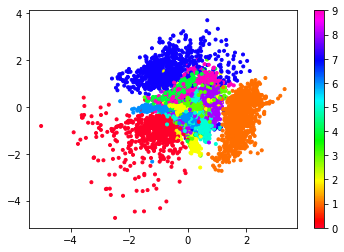

In [19]:
encoder = Model(x, mu)

x_test_latent = encoder.predict(X_test)
pyplot.figure()
pyplot.scatter(x_test_latent[:,0],x_test_latent[:, 1], marker = '.', c = y_test, cmap ='gist_rainbow')
pyplot.colorbar()

Decoder and visualize some sample generated digits

In [21]:
decoder_input = Input(shape=(2,))
z_decoded = z_decoder1(decoder_input)
z_decoded = z_decoder2(z_decoded)
z_decoded = z_decoder3(z_decoded)
y = y_decoder(z_decoded)

generator = Model(decoder_input, y)

generate 20 x 20 grid of variational digits. so 400 new digits that are not in the training dataset

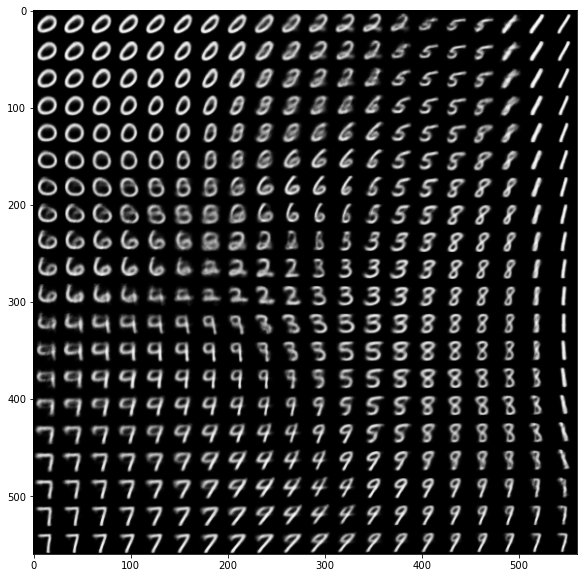

In [25]:
n = 20

figure = np.zeros((28 * n, 28 * n))

grid_x = norm.ppf(np.linspace(0.05, 0.95,n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample, verbose = 0)
        digit = x_decoded[0].reshape(28,28)
        figure[i * 28:(i+1)*28, j*28: (j+1)*28] = digit

pyplot.figure(figsize=(10, 10))
pyplot.imshow(figure, cmap ='gray')
pyplot.show()
                            

                  